Fine-tune bert: https://skimai.com/fine-tuning-bert-for-sentiment-analysis/

In [17]:
import re
import json
import numpy as np
import pandas as pd
from tqdm import tqdm
from collections import Counter
from unidecode import unidecode
from flair.data import Sentence
from flair.models import SequenceTagger
from flair.models import TextClassifier
from rich import print
from nltk.tokenize import sent_tokenize

import seaborn as sns
from matplotlib.colors import TwoSlopeNorm
import matplotlib.pyplot as plt

%matplotlib inline

def extract_names(docs, save=False):
    results = []
    
    for doc in docs:
        
        # split doc in sentences
        sentences = sent_tokenize(doc)
#         sentences = [e + "." for e in doc.split(".") if e]
        
        for sent in sentences:
            
            sentence = Sentence(sent, use_tokenizer=True)
            tagger.predict(sentence)

            for entity in sentence.get_spans('ner'):
                
                # Extract person and predict sentiment if person is in sentence
                if entity.tag == "PER":
                    classifier.predict(sentence)
                    score = sentence.get_labels()[0].score
                    value = sentence.get_labels()[0].value
                    name = entity.text
                    results.append((name, score, value))

    if save:
        with open(f'../data/{save}_names.json', 'w') as f:
            json.dump(results, f)
                
    return results


def extract_df(name_list):
    df = pd.DataFrame(name_list, columns=["Word", "Prob", "Sentiment"])
    df.Sentiment = df.Sentiment.map({"POSITIVE": 1, "NEGATIVE": -1})
    df.Word = df.Word.astype(str)
    df = preprocess_counts(df)
    return df


def preprocess_counts(df):
    """ Preprocess the data
    
    * Combine names such as Miguel and Miguel's by removing everything next to the special character 
    
    """
    # Remove accents
    df.Word = [unidecode(word) for word in df.Word]
    
    # Combine names such as Miguel and Miguel's by removing everything next to the special character
#     df.Word = df.Word.str.replace('[^A-z]',' ').str.strip().str.split(' ').str[0]  
    df.Word = df.Word.str.replace('[^A-z]',' ').str.strip()
    df = df.groupby("Word").agg({"Sentiment": [np.mean, np.count_nonzero]})
    df.columns = df.columns.droplevel()
    df = df.reset_index()
    df.columns = ["Word", "Sentiment", "Count"]
    df = df.sort_values("Count", ascending=False)
    
    # Remove names less than 3 characters
    df = df.loc[df.Word.str.len() >= 3, :]
    
    # Remove the "name" Disney
    df = df.loc[df.Word != "Disney", :]
    
    return df

**Load Model**  
This model was trained over the English CoNLL-03 task and can recognize 4 different entity types.

In [2]:
tagger = SequenceTagger.load('ner-fast')  # ner-fast for cpu-based predictions
classifier = TextClassifier.load('sentiment-fast')

2020-08-12 14:00:16,423 loading file /home/CORP.VANSPAENDONCKGROEP.NL/maarten.grootendorst/.flair/models/en-ner-fast-conll03-v0.4.pt
2020-08-12 14:00:21,003 loading file /home/CORP.VANSPAENDONCKGROEP.NL/maarten.grootendorst/.flair/models/sentiment-en-mix-ft-rnn.pt


**Load Data**

In [287]:
with open('../data/disney_reviews.json') as f:
    reviews = json.load(f)

docs = reviews['The Lion King']

**Generate Predictions**

In [288]:
new_docs = [sent_tokenize(doc) for doc in docs]
new_docs = [x for sublist in new_docs for x in sublist]
total_length = sum([len(x) for x in new_docs])
new_docs = [Sentence(x) for x in new_docs]

In [289]:
tagger.predict(new_docs, verbose=True)
classifier.predict(new_docs, verbose=True)

results = []
for sentence in new_docs:
    for token in sentence.get_spans('ner'):
        if token.tag == "PER":
            results.append((token.text, sentence.get_labels()[0].score, sentence.get_labels()[0].value))

Inferencing on batch 314: 100%|██████████| 314/314 [00:08<00:00, 36.98it/s]


In [290]:
df = pd.DataFrame(results, columns=["Word", "Prob", "Sentiment"])

# Preprocessing
df.Sentiment = df.Sentiment.map({"POSITIVE": 1, "NEGATIVE": -1})
df.Word = [unidecode(word) for word in df.Word]
df.Word = df.Word.str.replace('[^A-z]',' ').str.strip()
df.Word = [re.sub(r"\b[a-zA-Z]\b", "", word).strip() for word in df.Word.values]
df = df.loc[df.Word != "Disney", :]
df = df.loc[df.Word.str.len() >= 3, :]

# Finishing up
df = df.groupby("Word").agg({"Sentiment": [np.mean, np.count_nonzero]})
df.columns = df.columns.droplevel()
df = df.reset_index()
df.columns = ["Word", "Sentiment", "Count"]
df = df.sort_values("Count", ascending=False)

In [291]:
df.head(15)

,Word,Sentiment,Count
559,Simba,0.323913,920
518,Scar,0.098655,446
379,Mufasa,0.244681,376
640,Timon,0.573770,122
101,Elton John,0.661017,118
309,Lion King,0.355932,118
465,Pumbaa,0.600000,105
235,Jeremy Irons,0.588235,102
414,Nala,0.472527,91
149,Hakuna Matata,0.563218,87


**Visualize Results**  

Fix: 
* Miguel's
* ,Miguel
* Tom Hanks


**Preprocess Predictions**

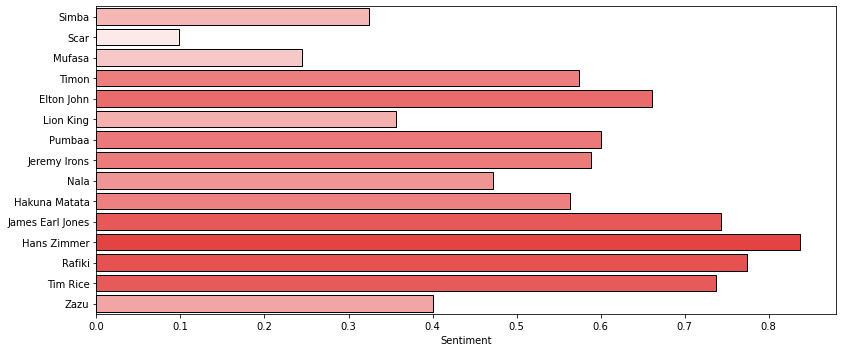

In [293]:
plt.figure(figsize=(12, 5))
norm = TwoSlopeNorm(vmin=-1, vcenter=0.0, 
                    vmax=1)
colors = [plt.cm.bwr(norm(c)) for c in df.Sentiment.head(15)]
ax = sns.barplot(x='Sentiment', y='Word', data=df.head(15), palette=colors, edgecolor='black')
plt.tight_layout()
plt.xlabel("Sentiment")
plt.ylabel("")
plt.show()
# plt.savefig("../images/lion_king.png", dpi=300)